In [65]:
# Dataset Link: https://www.kaggle.com/datasets/taejoongyoon/mitbit-arrhythmia-database/data

In [66]:
import numpy as np 
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout, Softmax,MaxPool1D
from keras.optimizers import Adam 
from keras.utils import to_categorical
from keras import regularizers


%matplotlib inline

# matplotlib Settings

In [67]:
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True 

# Method Definitions

In [68]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) # finds max level
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) # replaces signals below threshold as 0
        
    datarec = pywt.waverec(coeffs, 'sym4') # reconstructs wave
    
    return datarec


# Variables Definitions

In [ ]:
path = r'path_to_mitbhdb'
window_size = 180
maximum_counting = 10000

classes = ['N', 'SVEB', 'VEB', 'F', 'Q']
n_classes = len(classes)
count_classes = [0] * n_classes

X = list() # ecg segments
y = list() # annotation for each segment

# Preparing Input Files

In [70]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()

print(filenames)

['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt', '205.csv', '205annotations.txt', '207.csv', '207annotations.txt', '208.csv', '208annotations.txt', '209.csv'

In [71]:
# segregating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + '\\'  + filename + file_extension)

    # *.txt
    else:
        annotations.append(path +'\\' + filename + file_extension)
print(records[0])
print(annotations[0])

C:\Users\Anbarasan\Downloads\ECG-Classification-master_final\ECG-Classification-master\mit-bih-arrhythmia-database-1.0.0-csv\mitbih_database\mitbih_database\100.csv
C:\Users\Anbarasan\Downloads\ECG-Classification-master_final\ECG-Classification-master\mit-bih-arrhythmia-database-1.0.0-csv\mitbih_database\mitbih_database\100annotations.txt


# Extraction of Data and Preprocessing

In [72]:
def map_annotation(annotation_symbol):
    annotation_map = {
        'N': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',  # Normal
        'A': 'SVEB', 'a': 'SVEB', 'J': 'SVEB', 'S': 'SVEB', # SVEB
        'V': 'VEB', 'E': 'VEB',                          # VEB
        'F': 'F',                                  # Fusion
        'p': 'Q', '/': 'Q', 'f': 'Q', 'Q': 'Q'           # Unknown
    }
    return annotation_map.get(annotation_symbol, 'U')  # Default to U if not in map


<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Anbarasan\AppData\Local\Temp\ipykernel_7452\1775216497.py:13: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\Anbarasan\AppData\Local\Temp\ipykernel_7452\1775216497.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\Anbarasan\AppData\Local\Temp\ipykernel_7452\1775216497.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if r is 1:
C:\Users\Anbarasan\AppData\Local\Temp\ipykernel_7452\1775216497.py:55: SyntaxWarning: "

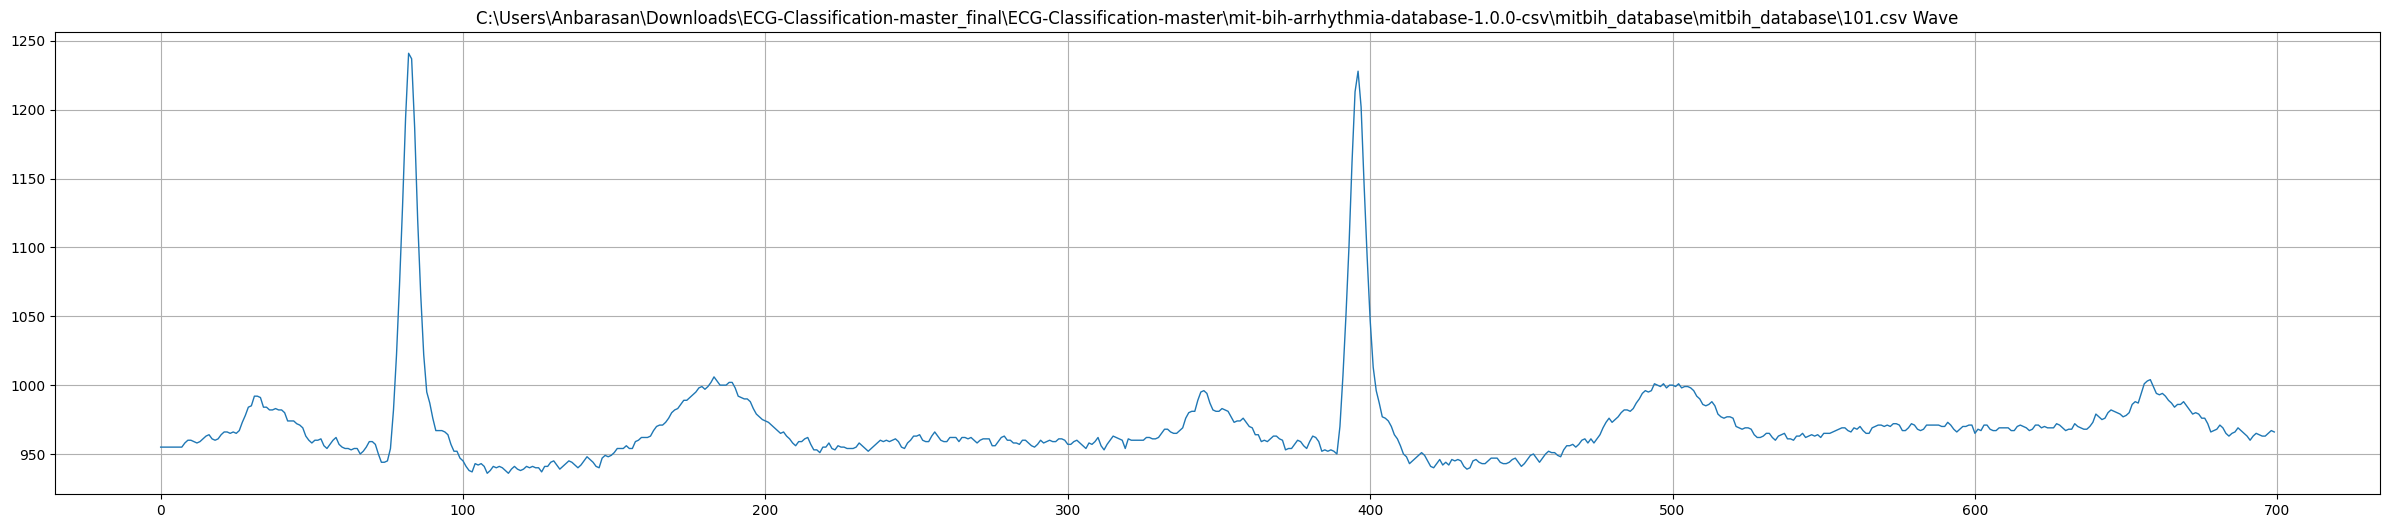

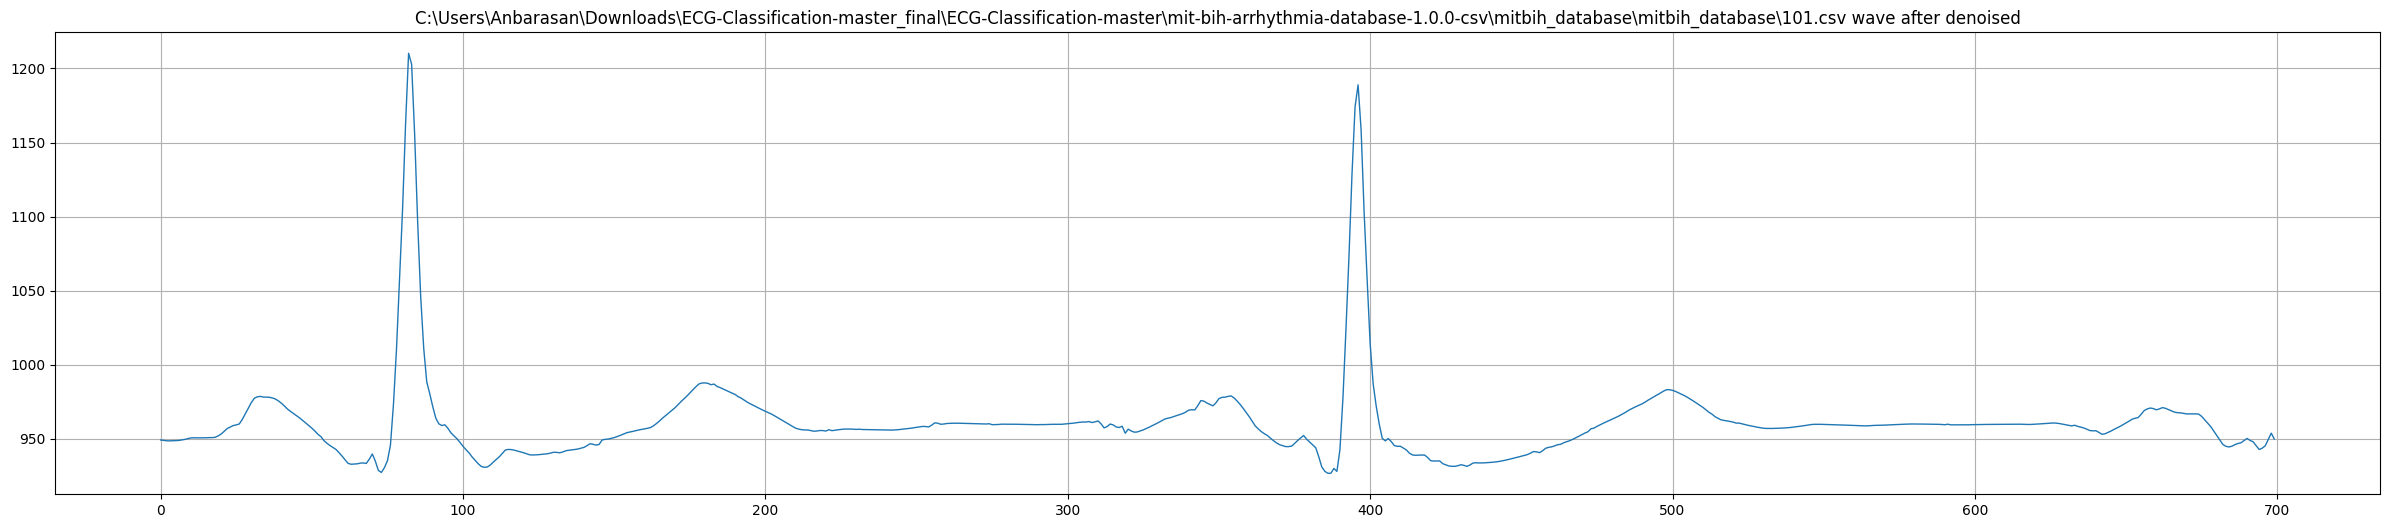

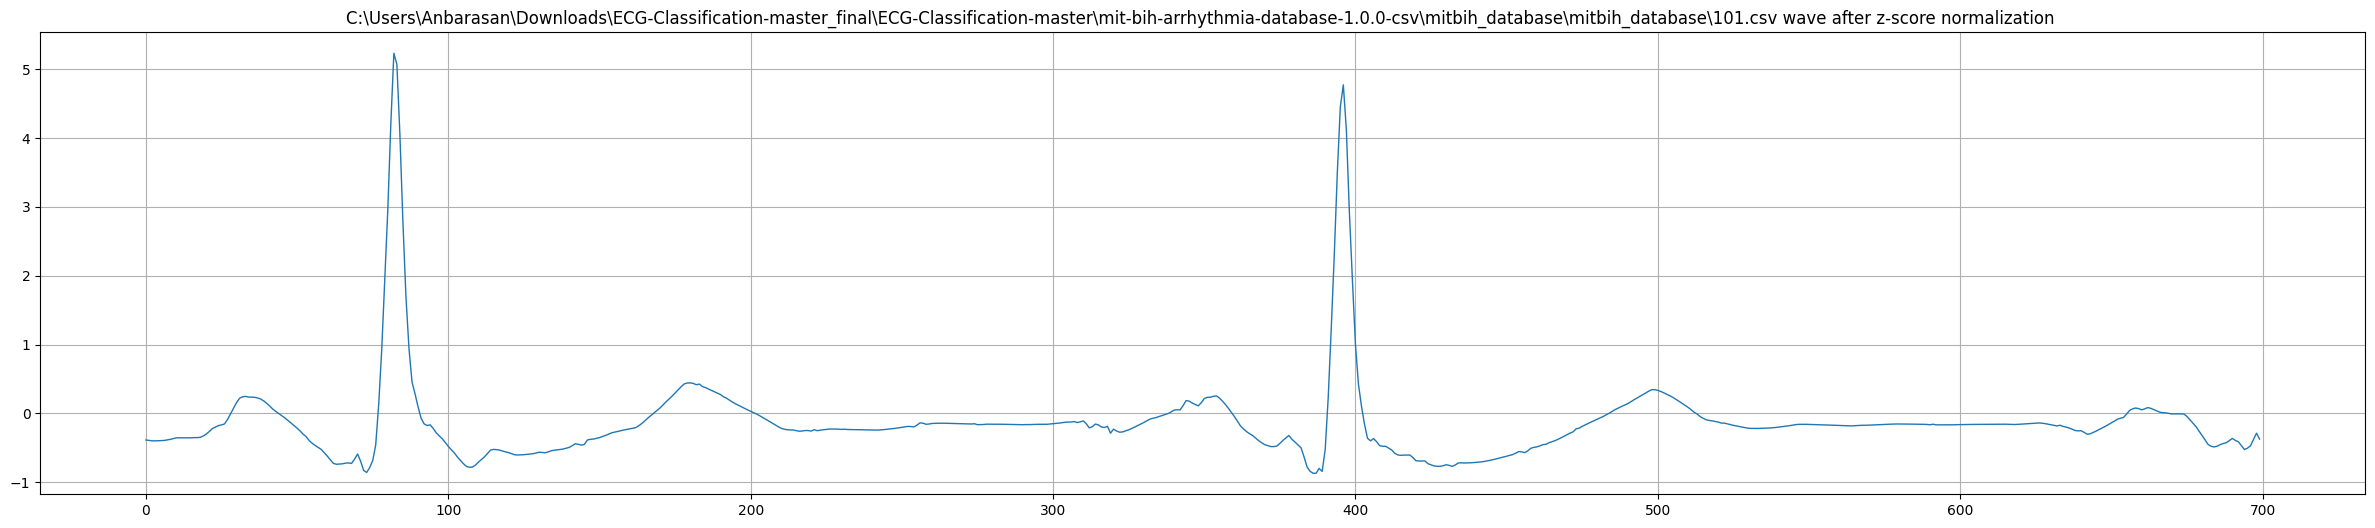

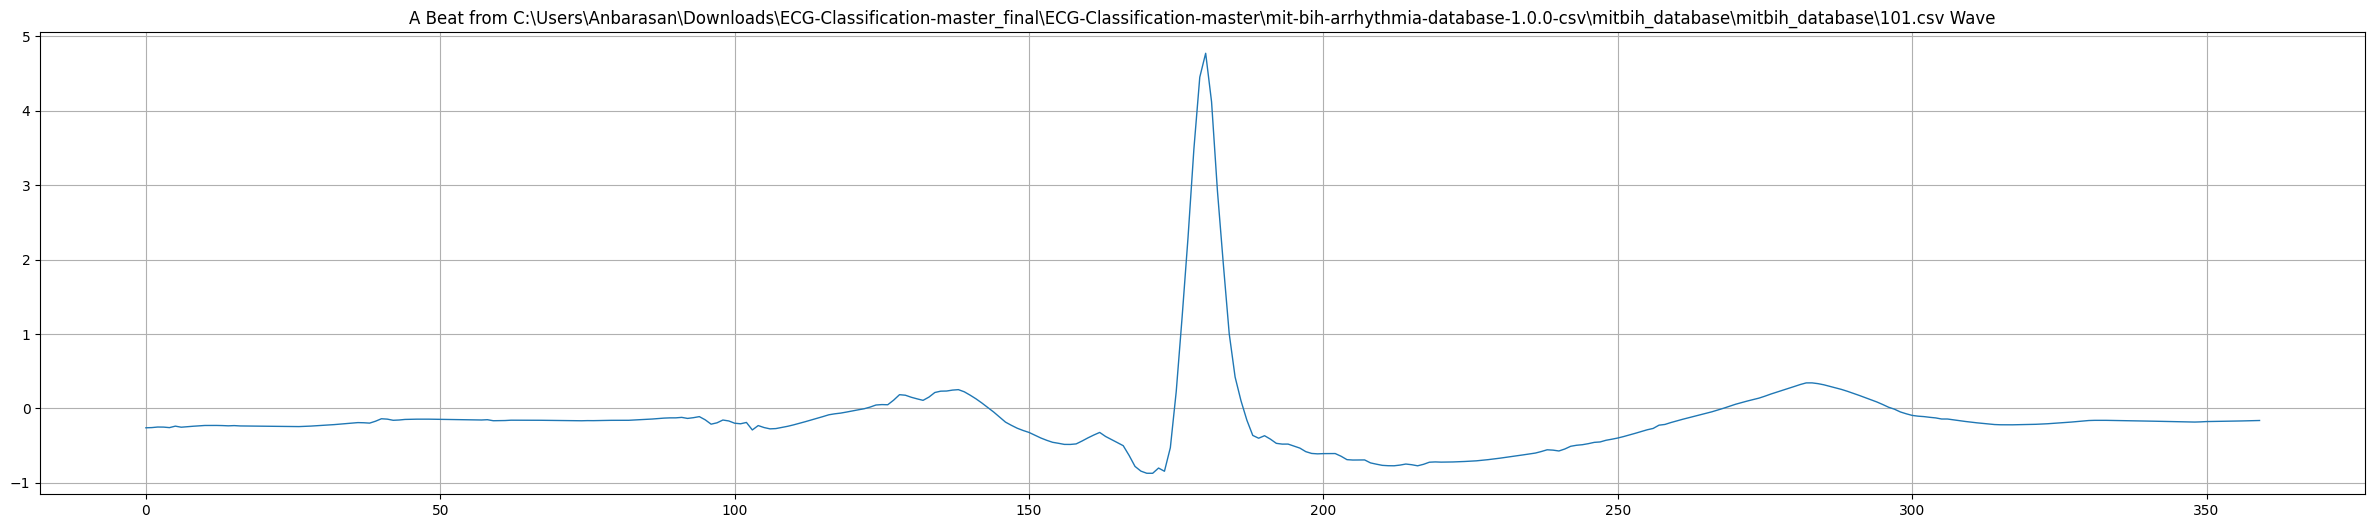

(109438, 360) (109438,)


In [73]:
# Records
for r in range(0, len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    
    # Plot an example to the signals
    signals = denoise(signals)
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r is 1:
        # Plot each patient's signal
        plt.title(records[1] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            arrhythmia_type = map_annotation(arrhythmia_type)
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from " + records[1] + " Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))


In [75]:
pip install peakutils


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


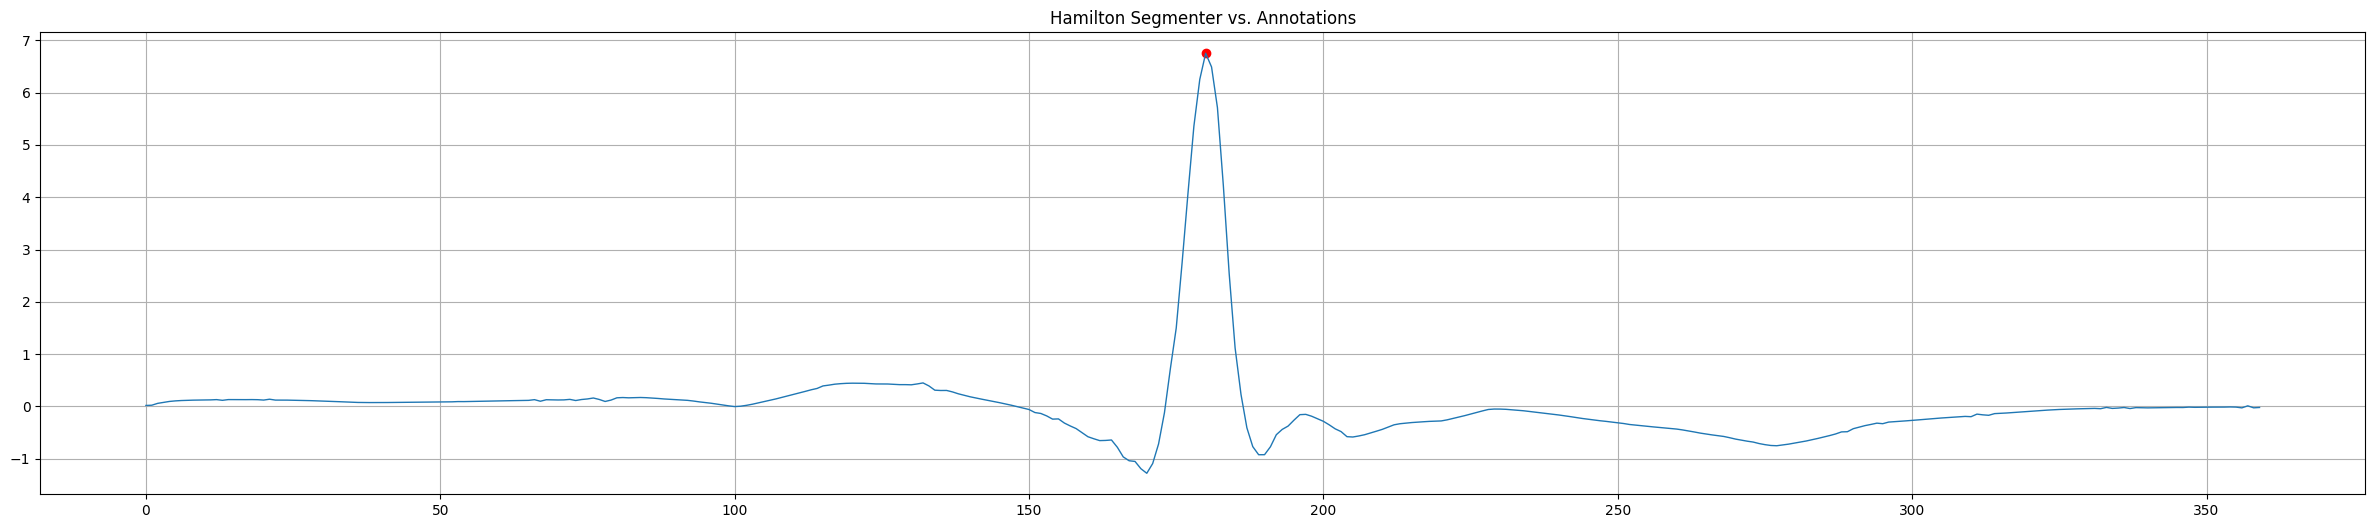

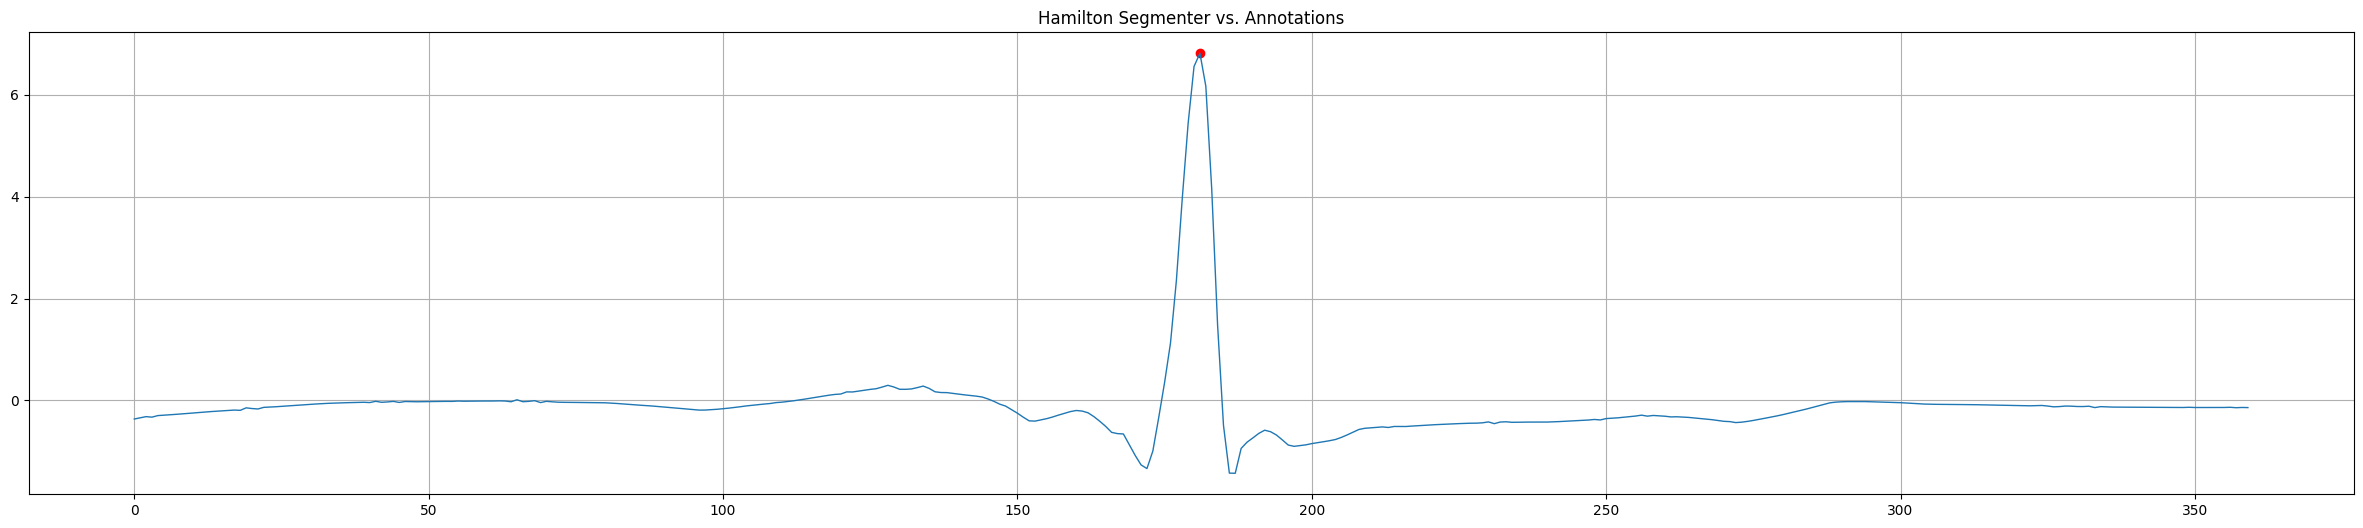

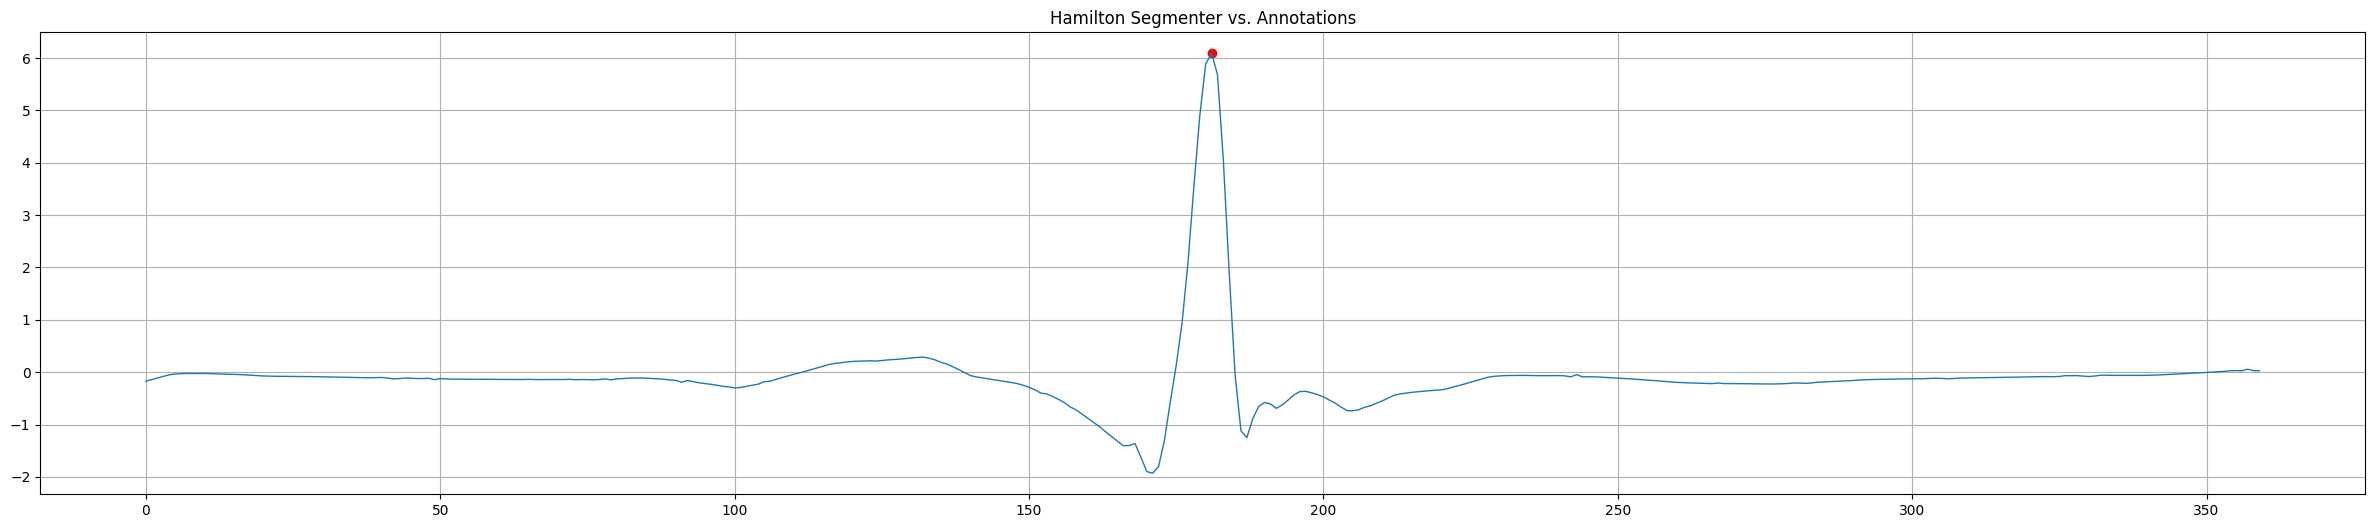

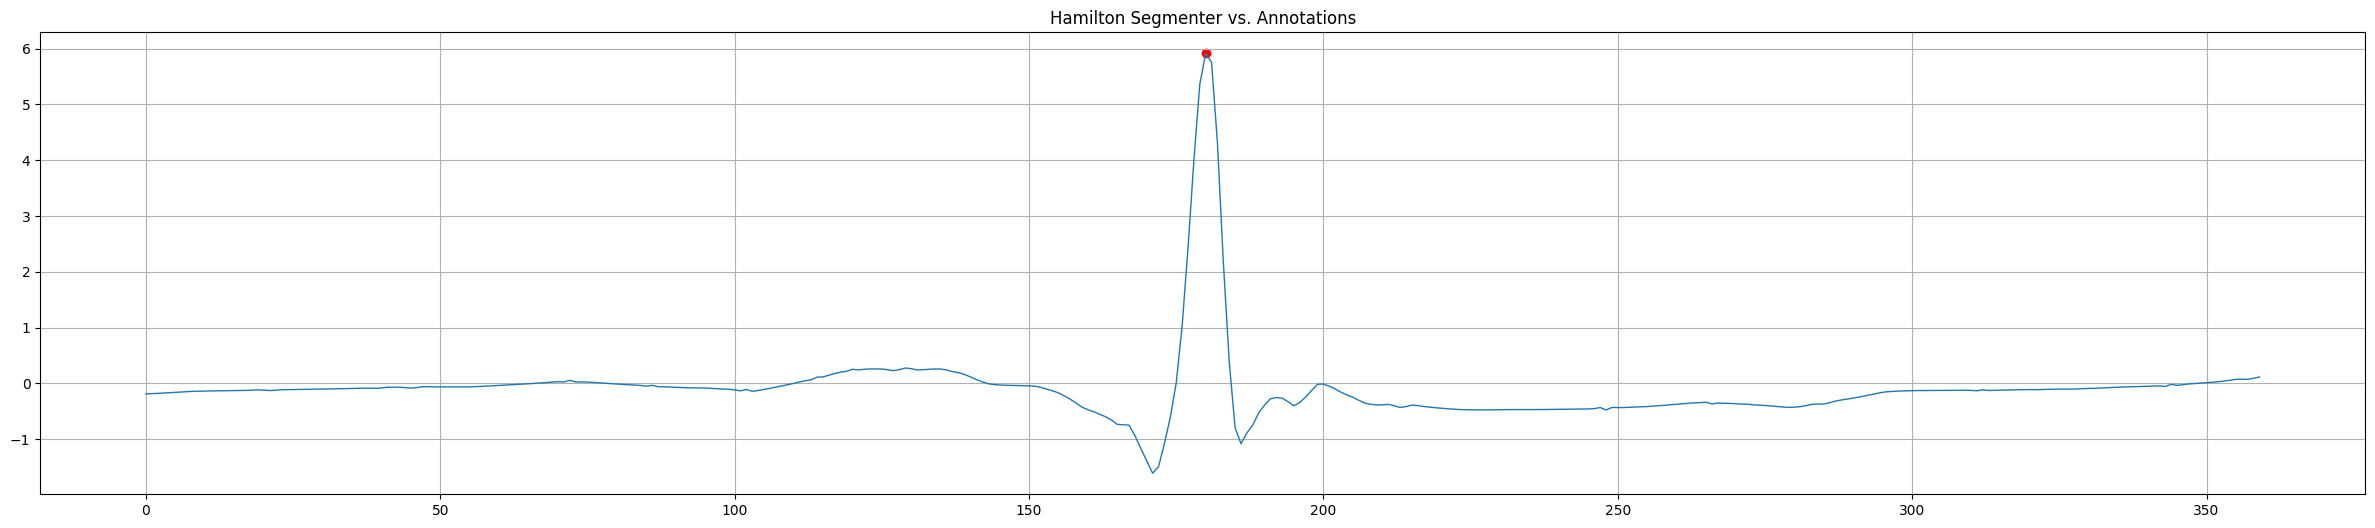

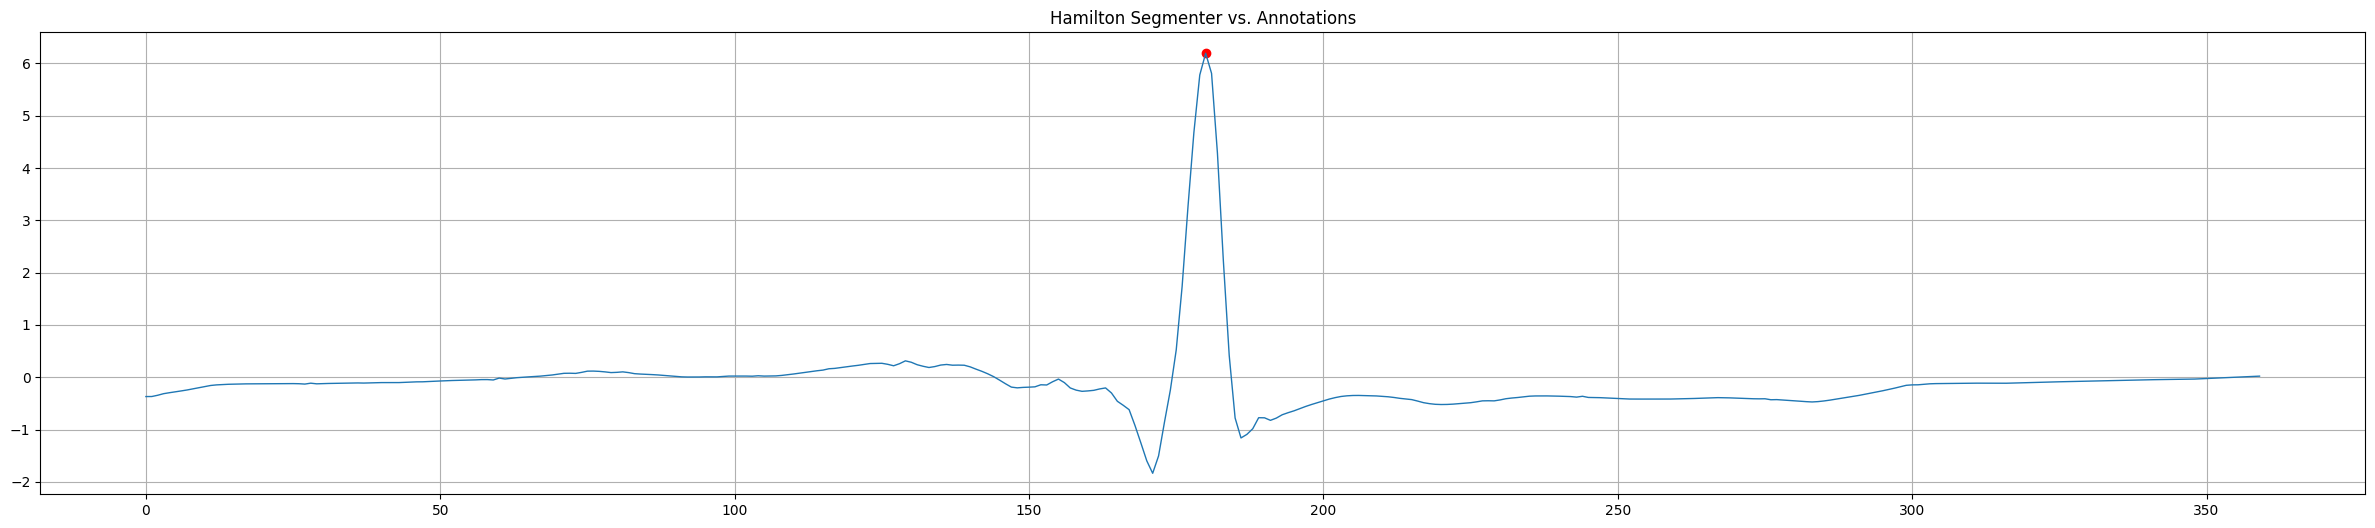

In [76]:
import biosppy

for i in range(5):
    rp = biosppy.signals.ecg.hamilton_segmenter(signal=X[i], sampling_rate=360)
    plt.plot(X[i])
    plt.scatter(rp, X[i][rp], color='red')
    plt.title("Hamilton Segmenter vs. Annotations")
    plt.show()

In [77]:
print(count_classes)

[90631, 2781, 7236, 803, 8043]


In [78]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i]) # Combining signals with annotations

print(np.shape(X))


(109438, 361)


In [79]:
print(X[1][23])

-0.13185492266505244


# EDA

In [80]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'SVEB', 'VEB', 'F', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

MemoryError: Unable to allocate 301. MiB for an array with shape (109438, 361) and data type object

In [ ]:
X_train_df.shape

(109438, 361)

In [ ]:
X_train_df.shape

(109438, 361)

In [ ]:
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==1])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==1])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==2])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==3])
print(X_train_df[X_train_df[X_train_df.shape[1]-1]==4])

             0         1         2         3         4         5         6    \
6      -0.438128 -0.400608 -0.427903 -0.417596 -0.408625 -0.402065 -0.396633   
229    -1.420898 -1.187409 -0.855263 -0.739026 -0.689668 -0.544793 -0.413792   
257    -0.499510 -0.516402 -0.538449 -0.532743 -0.564818 -0.572674 -0.584106   
341    -0.598011 -0.537693 -0.509940 -0.474848 -0.441343 -0.400385 -0.388625   
440    -0.341126 -0.403928 -0.422320 -0.433898 -0.480089 -0.528843 -0.523331   
...          ...       ...       ...       ...       ...       ...       ...   
108027  0.011064  0.020019  0.020210 -0.062848 -0.179377 -0.241565 -0.224210   
108028 -0.199883 -0.233213 -0.225296 -0.200810 -0.157652 -0.102724 -0.045633   
108029 -0.179152 -0.167557 -0.148743 -0.131663 -0.144787 -0.167190 -0.193901   
108030 -0.245442 -0.272487 -0.288598 -0.294246 -0.283440 -0.264564 -0.220207   
108031 -0.217312 -0.253542 -0.248535 -0.237988 -0.240676 -0.244632 -0.227949   

             7         8         9    .

# Rebalancing Classes

In [ ]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42) # selects random 5000 samples

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122) # upsampling minority classes
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)

X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

360
0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: count, dtype: int64


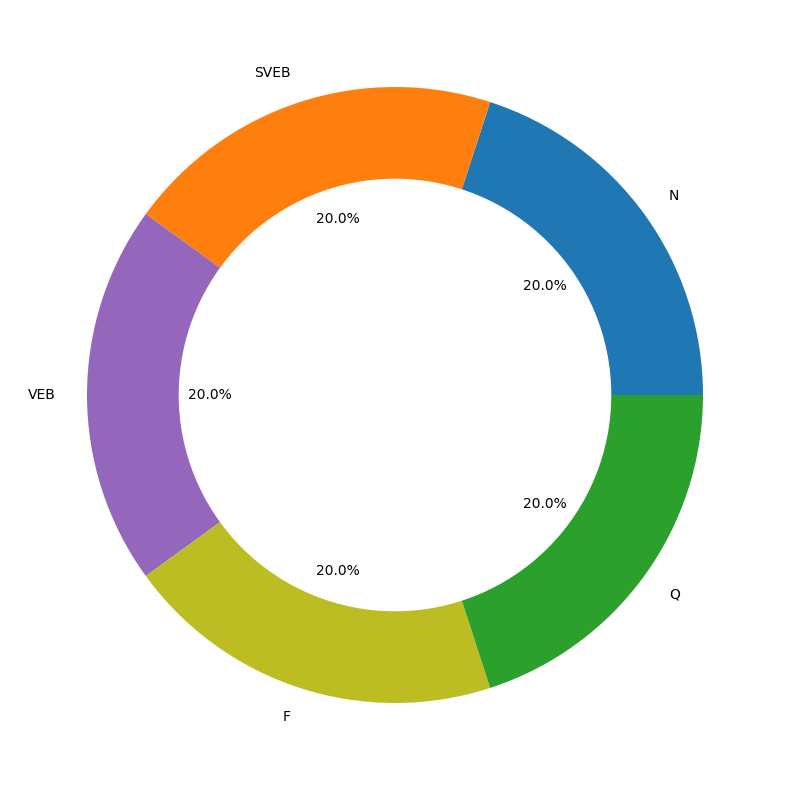

In [ ]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'SVEB', 'VEB', 'F', 'Q'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Train-Test Split

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [ ]:
target_train=train[train.shape[1]-1] # last column (annotation)
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train) # one hot encoding
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [ ]:
train

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
74108,-0.839255,-0.840837,-0.844694,-0.847055,-0.841251,-0.832134,-0.823836,-0.813941,-0.807820,-0.802911,...,-0.652432,-0.633130,-0.603934,-0.566110,-0.531629,-0.558561,-0.604418,-0.651929,-0.695520,3.0
103099,1.412460,1.446171,1.558391,1.580173,1.569869,1.671540,1.723518,1.782892,1.855014,1.912826,...,-0.103272,-0.042901,-0.078066,-0.041494,-0.049165,-0.041081,-0.036443,-0.021631,-0.018329,1.0
66267,0.131249,0.090456,0.064729,0.058869,-0.030365,-0.000243,-0.024700,-0.043804,-0.071676,-0.094979,...,0.281479,0.277584,0.277890,0.287268,0.270871,0.275137,0.274345,0.305941,0.304179,1.0
105257,1.132622,1.100155,1.060509,1.017707,0.987095,0.958825,0.917353,0.871588,0.830638,0.789292,...,-0.621371,-0.492577,-0.367292,-0.237941,-0.120120,-0.051837,-0.010246,0.004928,0.002816,0.0
75225,-0.999575,-0.967004,-0.963472,-0.969756,-0.979421,-0.990703,-0.988700,-0.982224,-0.976453,-0.970196,...,-0.728354,-0.735790,-0.738531,-0.723097,-0.702871,-0.672433,-0.642540,-0.649289,-0.668995,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4418,0.377472,0.440122,0.446702,0.481869,0.489883,0.498907,0.494333,0.463449,0.550862,0.454494,...,0.053997,0.047485,0.038991,0.028515,0.019100,-0.001562,-0.016984,-0.014013,-0.021744,4.0
103901,-0.631653,-0.642336,-0.651256,-0.664588,-0.680882,-0.687310,-0.691385,-0.725778,-0.767707,-0.776590,...,0.965774,0.988762,1.011199,1.031486,1.047473,1.062507,1.074129,1.086396,1.111101,3.0
64312,-0.328753,-0.326707,-0.327252,-0.326317,-0.324850,-0.325010,-0.324623,-0.318456,-0.309321,-0.300841,...,2.300496,2.188931,2.125063,2.114064,2.071399,1.998859,1.858302,1.693840,1.419086,3.0
75165,1.448645,0.671635,-0.047620,-0.672583,-1.056683,-1.282282,-1.268935,-1.129678,-0.971140,-0.795122,...,-0.121080,-0.121607,-0.122908,-0.126947,-0.130475,-0.121624,-0.107605,-0.097253,-0.086967,2.0


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values # leaving out the annotations (last index)
test_x = test.iloc[:,:test.shape[1]-1].values

train_x = train_x.reshape(len(train_x), train_x.shape[1],1) # making each element as a list of single element
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)

print(np.shape(train_x), np.shape(test_x))
print(np.shape(train_y),np.shape(test_y))

(20000, 360, 1) (5000, 360, 1)
(20000, 5) (5000, 5)


## Building the Model


In [ ]:
model = Sequential()

# Input - (360 x 1)
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=train_x[0].shape))
model.add(MaxPool1D(pool_size=3, strides=2))


model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))


model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))


model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=2))


model.add(Flatten())
model.add(Dropout(0.5))


model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))


model.add(Softmax())


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 360, 16)           224       
                                                                 
 max_pooling1d (MaxPooling1  (None, 179, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 179, 32)           7712      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 89, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 89, 64)            34880     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 44, 64)            0

## Compiling the model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

## Fitting the model

In [ ]:
history = model.fit(train_x, train_y, batch_size=75, epochs=50, verbose=1, validation_data=(test_x, test_y))

Epoch 1/50
267/267 [==============================] - 23s 78ms/step - loss: 0.4335 - accuracy: 0.8519 - val_loss: 0.2270 - val_accuracy: 0.9250
Epoch 2/50
267/267 [==============================] - 19s 70ms/step - loss: 0.2149 - accuracy: 0.9286 - val_loss: 0.1719 - val_accuracy: 0.9450
Epoch 3/50
267/267 [==============================] - 19s 71ms/step - loss: 0.1582 - accuracy: 0.9475 - val_loss: 0.1382 - val_accuracy: 0.9514
Epoch 4/50
267/267 [==============================] - 19s 71ms/step - loss: 0.1285 - accuracy: 0.9590 - val_loss: 0.0961 - val_accuracy: 0.9742
Epoch 5/50
267/267 [==============================] - 19s 70ms/step - loss: 0.1108 - accuracy: 0.9647 - val_loss: 0.1024 - val_accuracy: 0.9698
Epoch 6/50
267/267 [==============================] - 19s 71ms/step - loss: 0.0923 - accuracy: 0.9718 - val_loss: 0.1034 - val_accuracy: 0.9738
Epoch 7/50
267/267 [==============================] - 21s 79ms/step - loss: 0.0887 - accuracy: 0.9729 - val_loss: 0.0900 - val_accuracy:

**Plotting the loss convergence**

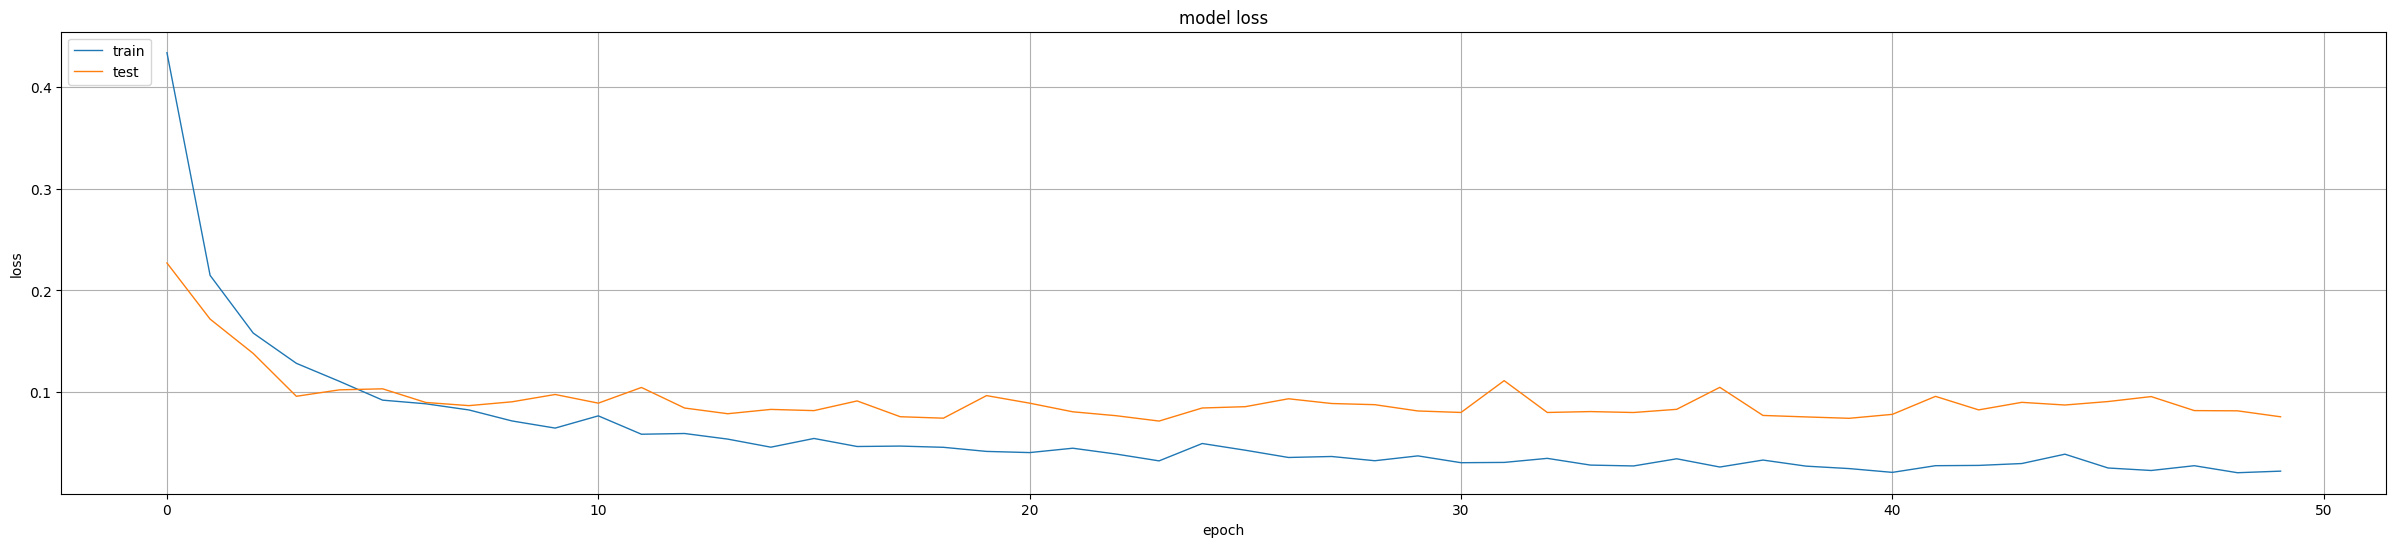

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Plotting accuracy**

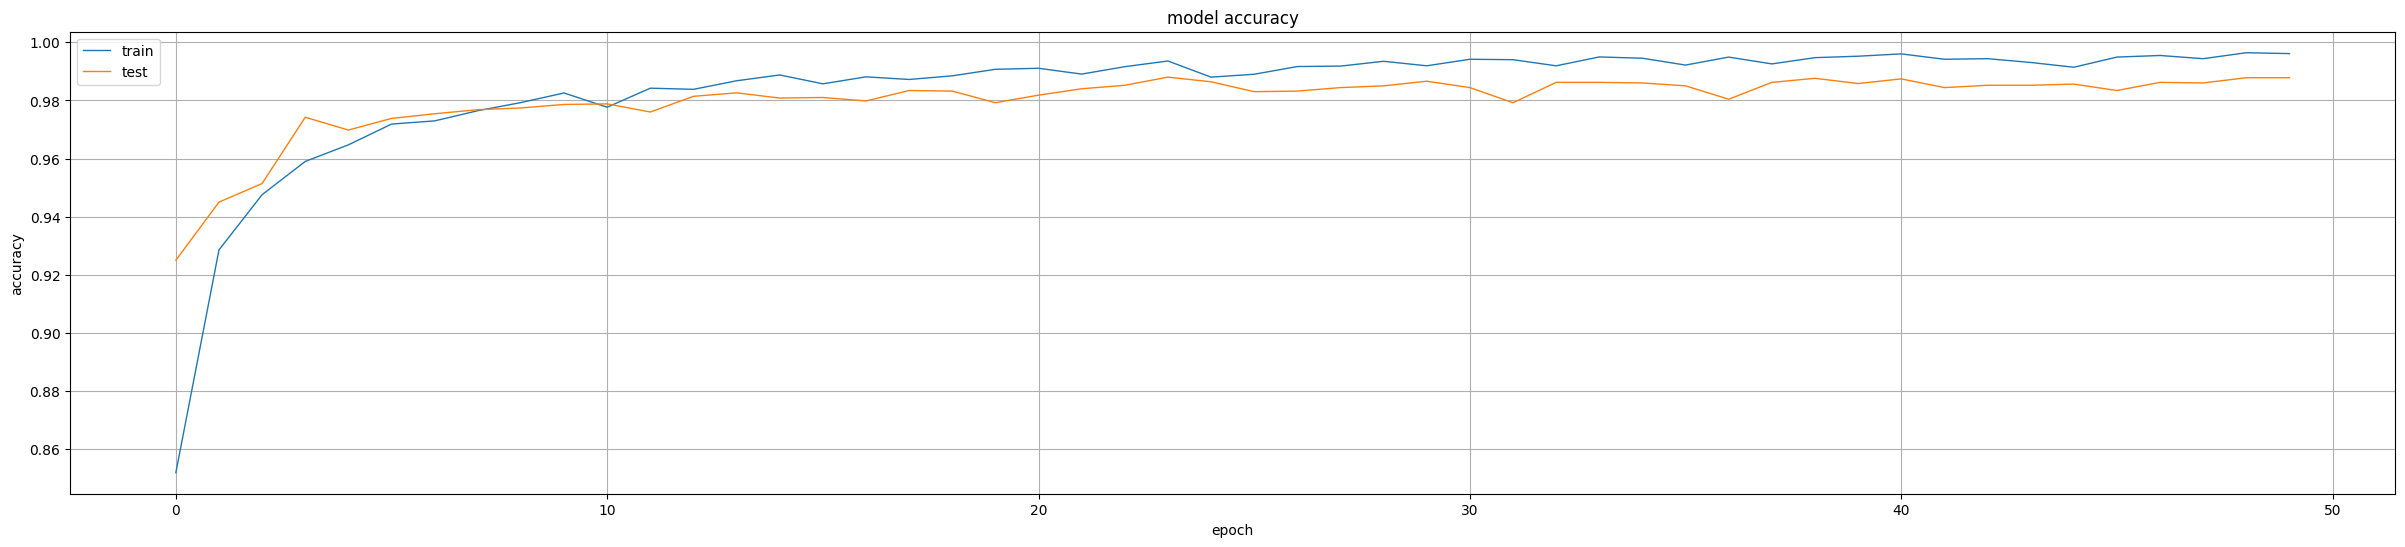

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save(f'arryhtmia-classification-{window_size}.h5')

c:\Users\Pranesh\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Finding the loss and accuracy of the model

In [ ]:
score = model.evaluate(test_x, test_y)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

157/157 [==============================] - 2s 14ms/step - loss: 0.0760 - accuracy: 0.9878
Test Loss: 0.0759764164686203
Test accuracy: 0.9878000020980835


157/157 [==============================] - 2s 14ms/step


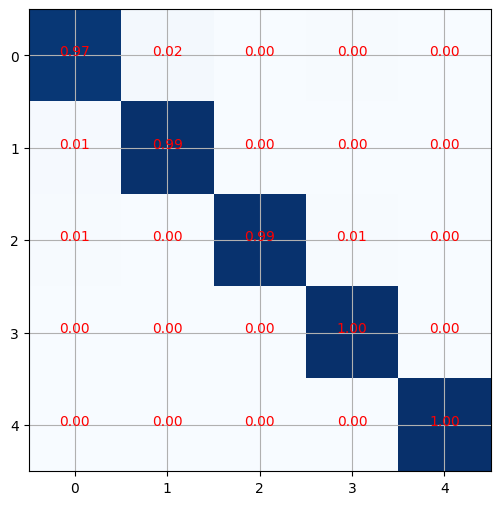

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
pred_y = model.predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="red")


plt.imshow(cm, cmap=plt.cm.Blues)

157/157 [==============================] - 2s 14ms/step


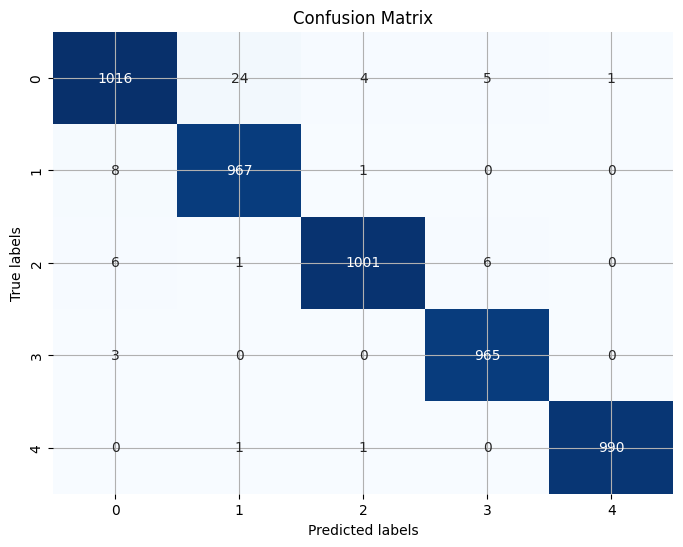

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict and calculate the confusion matrix without normalization
pred_y = model.predict(test_x)
cm = confusion_matrix(test_y.argmax(axis=1), pred_y.argmax(axis=1))

# Create a heatmap with integer annotations
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

# Set labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

plt.show()

In [ ]:
# Test data class labels spread

print("The distribution of test set labels")
print(test[X_train_df.shape[1]-1].value_counts())

print('F1_score = ', f1_score(test_y.argmax(axis=1), pred_y.argmax(axis=1), average = 'macro'))


The distribution of test set labels
360
0.0    1050
2.0    1014
4.0     992
1.0     976
3.0     968
Name: count, dtype: int64
F1_score =  0.9879249540235879


Actual label:  SVEB
Model prediction :  SVEB  with probability  1.0


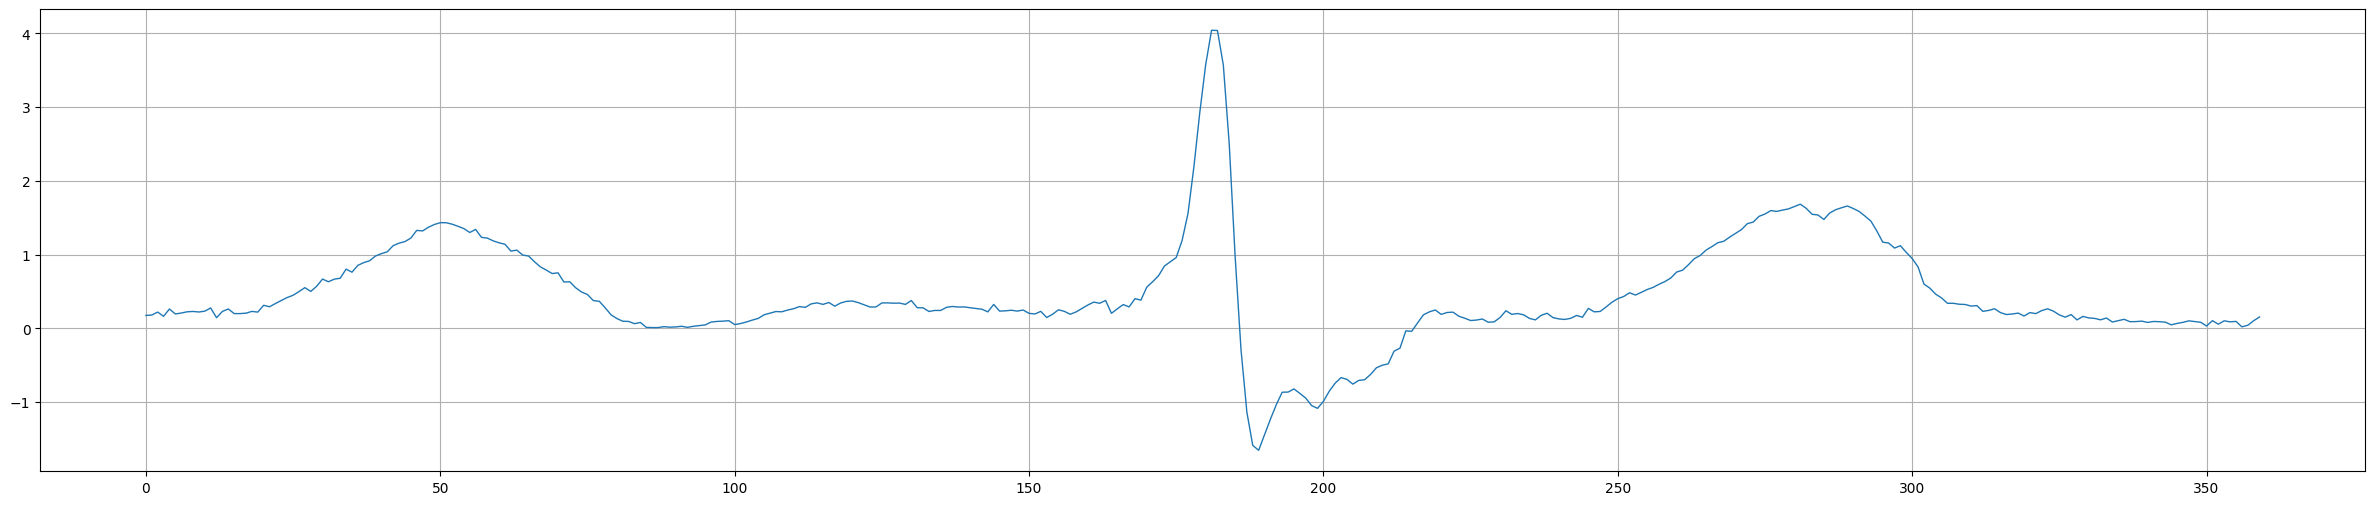

In [ ]:
import random
i = random.randint(0, len(test_x)-1)

output = model(np.expand_dims(test_x[i], 0))

pred = output.numpy()[0]

plt.plot(test_x[i])

print("Actual label: ", classes[np.argmax(test_y[i])])
print("Model prediction : ", classes[np.argmax(pred)], " with probability ", pred[np.argmax(pred)])

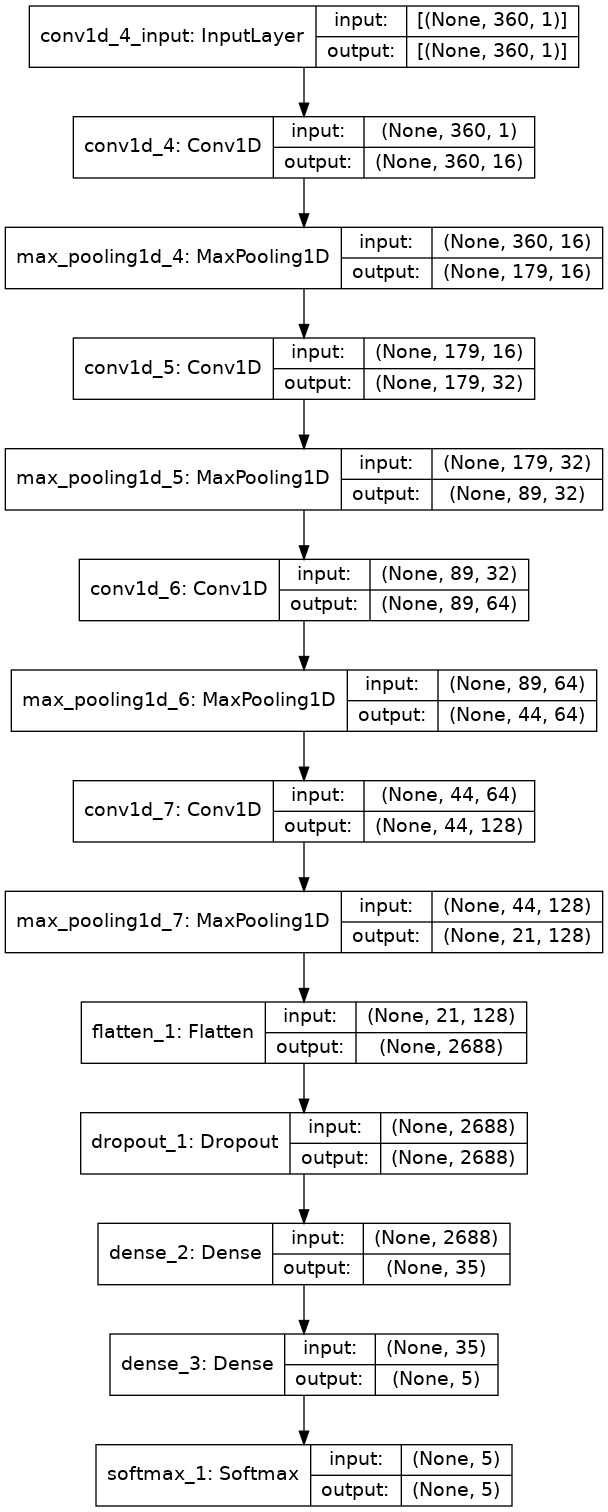

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict the labels on the test data
pred_y = model.predict(test_x)
pred_classes = pred_y.argmax(axis=1)
true_classes = test_y.argmax(axis=1)

# Classification report
report = classification_report(true_classes, pred_classes, target_names=classes)
print("Classification Report:\n", report)

# Calculate total samples, correct predictions, and overall accuracy
total_samples = len(test_y)
correct_predictions = (pred_classes == true_classes).sum()
overall_accuracy = accuracy_score(true_classes, pred_classes)

print(f"Total samples: {total_samples}")
print(f"Correct predictions: {correct_predictions}")
print(f"Overall accuracy: {overall_accuracy:.2f}")


157/157 [==============================] - 2s 14ms/step
Classification Report:
               precision    recall  f1-score   support

           N       0.98      0.97      0.98      1050
        SVEB       0.97      0.99      0.98       976
         VEB       0.99      0.99      0.99      1014
           F       0.99      1.00      0.99       968
           Q       1.00      1.00      1.00       992

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000

Total samples: 5000
Correct predictions: 4939
Overall accuracy: 0.99


In [ ]:
import pickle

# Save the data to a pickle file
with open('train_x.pkl', 'wb') as f:
    pickle.dump(train_x, f)
    
with open('test_x.pkl', 'wb') as f:
    pickle.dump(test_x, f)
    
with open('train_y.pkl', 'wb') as f:
    pickle.dump(train_y, f)
    
with open('test_y.pkl', 'wb') as f:
    pickle.dump(test_y, f)

with open('x_train_df.pkl', 'wb') as f:
    pickle.dump(X_train_df, f)

print("Data saved successfully.")

Data saved successfully.


In [ ]:
# import pickle

# # Load the data from pickle files
# with open('train_x.pkl', 'rb') as f:
#     train_x = pickle.load(f)
    
# with open('test_x.pkl', 'rb') as f:
#     test_x = pickle.load(f)
    
# with open('train_y.pkl', 'rb') as f:
#     train_y = pickle.load(f)
    
# with open('test_y.pkl', 'rb') as f:
#     test_y = pickle.load(f)

# with open('x_train_df.pkl', 'rb') as f:
#     X_train_df = pickle.load(f)

# print("Data loaded successfully.")


#  Hypothesis Testing

## Normality Testing

Null Hypothesis (H₀): The ECG signal data follows a normal distribution
Alternative Hypothesis (H₁): The ECG signal data does not follow a normal distribution

Recommended Tests:
Kolmogorov-Smirnov test
Q-Q plots for visual confirmation

In [ ]:
import pywt

def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) # finds max level
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) # replaces signals below threshold as 0
        
    datarec = pywt.waverec(coeffs, 'sym4') # reconstructs wave
    
    return datarec

Testing normality for file: F:/SDP - II/mit-bih-arrhythmia-database-1.0.0-csv/mitbih_database/100.csv

Kolmogorov-Smirnov Test (for larger datasets):
Statistic: 0.1533833811002956, p-value: 0.0
Reject H₀: The data does not follow a normal distribution.


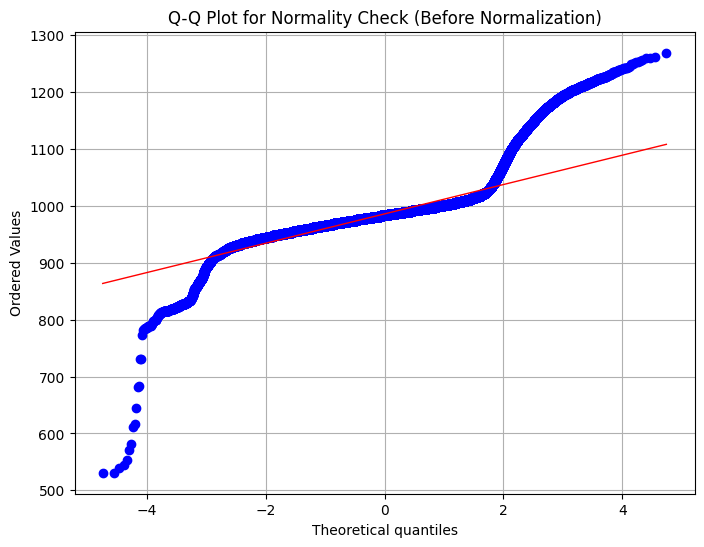

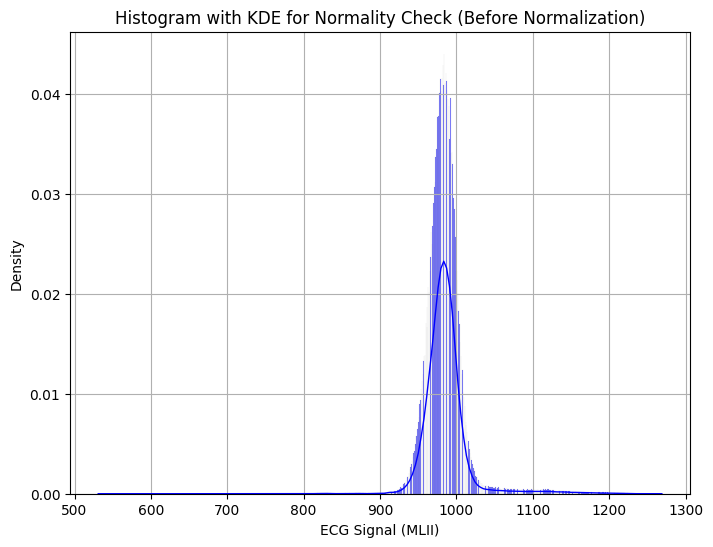


Z-score normalization applied.

Kolmogorov-Smirnov Test (for larger datasets) after Normalization:
Statistic: 0.15444674502433342, p-value: 0.0
Reject H₀: The normalized data does not follow a normal distribution.


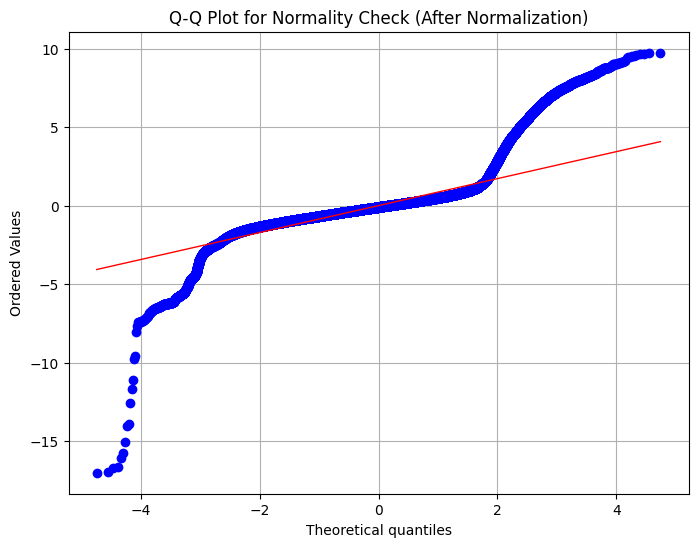

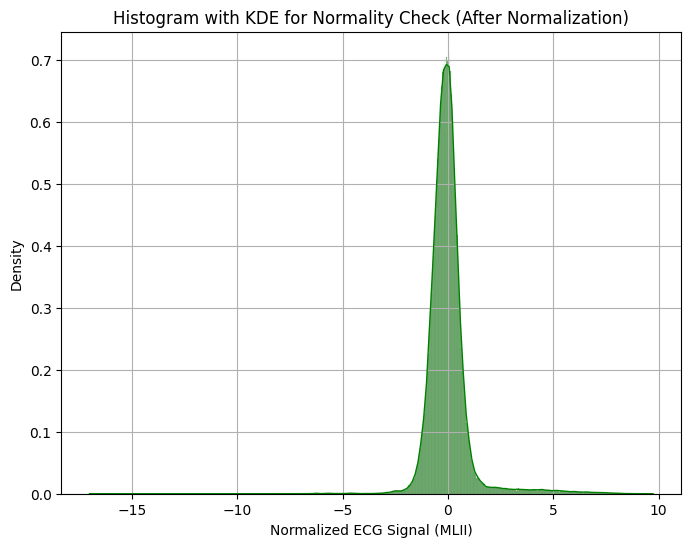

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

def test_normality_and_normalize(file_path):
    # Read the CSV file containing ECG data (MLII column is index 1)
    df = pd.read_csv(file_path)
    ml_ii = df.iloc[:, 2]  # Extract MLII column
    
    # Check size of the dataset to choose appropriate test
    n = len(ml_ii)

    print(f"Testing normality for file: {file_path}")

    # Original normality testing

    # Kolmogorov-Smirnov test (for larger datasets) N > 5000
    print("\nKolmogorov-Smirnov Test (for larger datasets):")
    stat, p_value = stats.kstest(ml_ii, 'norm', args=(np.mean(ml_ii), np.std(ml_ii)))
    print(f"Statistic: {stat}, p-value: {p_value}")
    if p_value > 0.05:
        print("Fail to reject H₀: The data appears to be normally distributed.")
    else:
        print("Reject H₀: The data does not follow a normal distribution.")

    # Q-Q plot for visual confirmation
    plt.figure(figsize=(8, 6))
    stats.probplot(ml_ii, dist="norm", plot=plt)
    plt.title("Q-Q Plot for Normality Check (Before Normalization)")
    plt.show()

    # Histogram for further visualization
    plt.figure(figsize=(8, 6))
    sns.histplot(ml_ii, kde=True, color='blue', stat='density')
    plt.title("Histogram with KDE for Normality Check (Before Normalization)")
    plt.xlabel("ECG Signal (MLII)")
    plt.ylabel("Density")
    plt.show()

    # Z-score Normalization
    normalized_ml_ii = stats.zscore(denoise(ml_ii))
    print("\nZ-score normalization applied.")

    # Normality testing after Z-score normalization

    # Kolmogorov-Smirnov test (for larger datasets)
    print("\nKolmogorov-Smirnov Test (for larger datasets) after Normalization:")
    stat, p_value = stats.kstest(normalized_ml_ii, 'norm', args=(np.mean(normalized_ml_ii), np.std(normalized_ml_ii)))
    print(f"Statistic: {stat}, p-value: {p_value}")
    if p_value > 0.05:
        print("Fail to reject H₀: The normalized data appears to be normally distributed.")
    else:
        print("Reject H₀: The normalized data does not follow a normal distribution.")

    # Q-Q plot for visual confirmation after normalization
    plt.figure(figsize=(8, 6))
    stats.probplot(normalized_ml_ii, dist="norm", plot=plt)
    plt.title("Q-Q Plot for Normality Check (After Normalization)")
    plt.show()

    # Histogram for further visualization after normalization
    plt.figure(figsize=(8, 6))
    sns.histplot(normalized_ml_ii, kde=True, color='green', stat='density')
    plt.title("Histogram with KDE for Normality Check (After Normalization)")
    plt.xlabel("Normalized ECG Signal (MLII)")
    plt.ylabel("Density")
    plt.show()


test_normality_and_normalize('F:/SDP - II/mit-bih-arrhythmia-database-1.0.0-csv/mitbih_database/100.csv')


## Class Distribution Analysis
Null Hypothesis (H₀): The different heartbeat types (e.g., Normal, Supraventricular, Ventricular, etc.) are evenly distributed across the dataset. This means each type occurs with approximately equal frequency.

Alternate Hypothesis (H₁): The different heartbeat types are not evenly distributed across the dataset. This implies that certain types may be more or less prevalent, indicating an unequal distribution of heartbeat types.

In [ ]:
import pandas as pd
from scipy.stats import chisquare

# Function to load and parse annotations from a file
def load_annotation_data(filename):
    # Read the annotations from the .txt file (adjust the delimiter if necessary)
    # Assuming columns are separated by whitespace
    annotations = pd.read_csv(filename, delim_whitespace=True, skiprows=1, 
                              names=['Time', 'Sample', 'Type', 'Sub', 'Chan', 'Num', 'Aux'])
    
    # Extract only the 'Type' column to analyze heartbeat types
    heartbeat_types = annotations['Type']
    
    return heartbeat_types

# Function to count the occurrences of each heartbeat type
def count_heartbeat_types(heartbeat_types):
    return heartbeat_types.value_counts()

# Perform the Chi-Square Goodness of Fit Test
def chi_square_goodness_of_fit(counts):
    # Expected frequency assumes equal distribution
    expected_frequency = [counts.sum() / len(counts)] * len(counts)
    
    # Perform chi-square goodness of fit test
    chi2_stat, p_value = chisquare(f_obs=counts.values, f_exp=expected_frequency)
    return chi2_stat, p_value

# Main function
def main():
    # Load the annotation data
    filename = 'F:/SDP - II/mit-bih-arrhythmia-database-1.0.0-csv/mitbih_database/100annotations.txt' 
    heartbeat_types = load_annotation_data(filename)
    
    # Count occurrences of each type
    type_counts = count_heartbeat_types(heartbeat_types)
    print("Heartbeat Type Counts:\n", type_counts)
    
    # Perform Chi-Square Test for Goodness of Fit
    chi2_stat, p_value = chi_square_goodness_of_fit(type_counts)
    print("\nChi-Square Statistic:", chi2_stat)
    print("p-value:", p_value)
    
    # Inference
    if p_value < 0.05:
        print("The heartbeat types are not evenly distributed (statistically significant).")
    else:
        print("No significant evidence that the heartbeat types are unevenly distributed.")

# Run the main function
main()


Heartbeat Type Counts:
 Type
N    2239
A      33
+       1
V       1
Name: count, dtype: int64

Chi-Square Statistic: 6546.073878627969
p-value: 0.0
The heartbeat types are not evenly distributed (statistically significant).


C:\Users\Pranesh\AppData\Local\Temp\ipykernel_56180\1113529462.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  annotations = pd.read_csv(filename, delim_whitespace=True, skiprows=1,


## Effect of resampling
H₀: The proportion of arrhythmia classes is uniform after resampling

H₁: The proportion of arrhythmia classes is not uniform after resampling

Recommended Test: Chi-square goodness of fit test

In [ ]:
from scipy.stats import chisquare

# Get the observed frequencies for each class in the resampled data
observed_freq = X_train_df[X_train_df.shape[1]-1].value_counts().values

# Define the expected frequencies assuming a uniform distribution
expected_freq = [len(X_train_df) / len(classes)] * len(classes)

# Perform the Chi-square goodness of fit test
chi2_stat, p_val = chisquare(observed_freq, expected_freq)

# Print the results
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")

# Conclusion based on p-value
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis H₀: The proportion of arrhythmia classes is not uniform after resampling.")
else:
    print("Fail to reject the null hypothesis H₀: The proportion of arrhythmia classes is uniform after resampling.")


Chi-square Statistic: 0.0
P-value: 1.0
Fail to reject the null hypothesis H₀: The proportion of arrhythmia classes is uniform after resampling.
